# 1 - Loading and Auto-process Data

The review data most compatible with film_review_explorer is the data scraped with [film_review_scrape](https://github.com/pip-chang/film_review_scraper), but as long as the input data are JSONL files (each line representing one review) it's fine. Please remember to change the column names accordingly.

When reading JSONL files and/or folders with JSONL files, make sure you enter the full path:

In [1]:
from src.film_review_explorer import read_jsonl_to_dataframe
df = read_jsonl_to_dataframe("/Users/pipchang/Documents/VSC/Projects/DH-S/download/Top_Gun_Maverick")  # replace with your own
df.sample(3)

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio
2716,2022-05-28,4/5,0.8,A Cruise Style,Douban,,11.0,NaN,NaN,NaN,NaN
3416,2023-06-25,4/5,0.8,好看的，要是去掉感情戏就更好了！,Douban,福建,0.0,NaN,NaN,NaN,NaN
6711,2022-06-28,10/10,1.0,A sequel without it feeling like one: One of m...,IMDB,NaN,2.0,4.0,/review/rw8282716/?ref_=tt_urv,NaN,0.5


You can inspect what datatypes are the values in each column:

In [2]:
from src.film_review_explorer import get_column_types
get_column_types(df)

{'date': 'Timestamp',
 'rating': 'NoneType, str',
 'rating_ratio': 'float',
 'review': 'str',
 'website': 'str',
 'location': 'NoneType, float, str',
 'upvotes': 'float',
 'total_votes': 'float',
 'permalink': 'float, str',
 'comments': 'list, float',
 'like_ratio': 'float'}

Basic processing include basic cleaning of text, calculating rating level and like level:

In [3]:
from src.film_review_explorer import auto_basic_process
auto_basic_process(df)
df.sample(3)

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio,review_length,rating_level,like_level
6126,2022-06-21,10/10,1.0,One of the Best Films The Last 5+ Years: It's ...,IMDB,NaN,2.0,4.0,/review/rw8260877/?ref_=tt_urv,NaN,0.500000,43,Good (>=8/10),Somewhat Disgree (20%~50%)
4737,2022-06-01,10/10,1.0,Worth the waiting: I watched the first movie i...,IMDB,NaN,4.0,5.0,/review/rw8194769/?ref_=tt_urv,NaN,0.800000,39,Good (>=8/10),Mostly Agree (>80%)
6138,2022-08-28,7/10,0.7,I saw the score and I thought it was going to ...,IMDB,NaN,1.0,3.0,/review/rw8493782/?ref_=tt_urv,NaN,0.333333,362,Ok (4~8/10),Somewhat Disgree (20%~50%)


# 2 - Basic Inspection with Plotting

It's good to have a general inspection of our data first in order to analyze further after. We can make some plots to discover trends.

Here I will only show a few with seaborn, but there are many other libraries to visualize data, such as [plotly](https://plotly.com/python/).

We'll use matplotlib widget to create interactive plots that have pan and zoom functionality, toolbar buttons, and save plot.

In [4]:
%matplotlib widget

A general overview:

In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,7691,2022-10-01 11:55:13.535301120,2019-10-04 00:00:00,2022-06-04 00:00:00,2022-08-22 00:00:00,2023-01-20 00:00:00,2023-07-07 00:00:00,NaN
rating_ratio,7599.0,0.784774,0.1,0.6,0.9,1.0,1.0,0.245601
upvotes,6951.0,15.975111,0.0,0.0,2.0,4.0,5140.0,130.290189
total_votes,4331.0,17.664281,0.0,3.0,5.0,9.0,5406.0,114.707416
like_ratio,4178.0,0.519917,0.0,0.333333,0.5,0.666667,1.0,0.255874
review_length,7691.0,119.492264,1.0,32.0,64.0,133.0,25977.0,376.628684


From above we can see that 75% of reviews are shorter than 133 words. 

When plotting, it's better to not include outliers so that we can see the general trend better. So we'll filter the dataframe when plotting.

NOTE: Though you can also use the zoom-in to filter

In [10]:
df['website'].value_counts()

website
IMDB               4223
Douban             2728
Rotten Tomatoes     740
Name: count, dtype: int64

From the above we can see that most reviews are from IMDB.

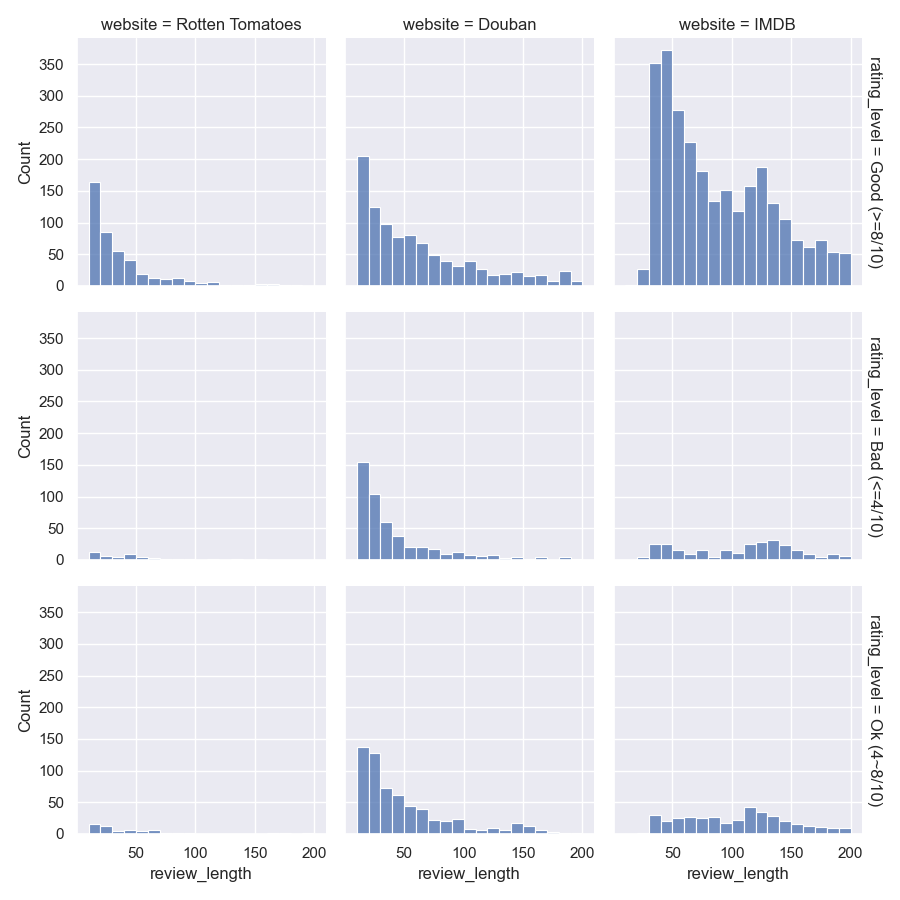

In [13]:
import seaborn as sns

sns.set_theme(style="darkgrid")
ax = sns.displot(
    df.query('review_length <= 200 and review_length >= 10'),  # We filter out reviews that are longer than 200 or shorter than 10 words
    x="review_length", col="website", row="rating_level",
    binwidth=10, height=3, facet_kws=dict(margin_titles=True),
)

Some observations from the above plot:

1. IMDB reviews are overwhelmingly positive, whereas Douban reviews are quite equally distributed across the three rating levels
-> The Chinese viewers are more critical towards "Top Gun: Maverick" than the English-speaking viewers
2. IMDB reviews tend to be a bit longer overall

We can have a better look at the distribution:


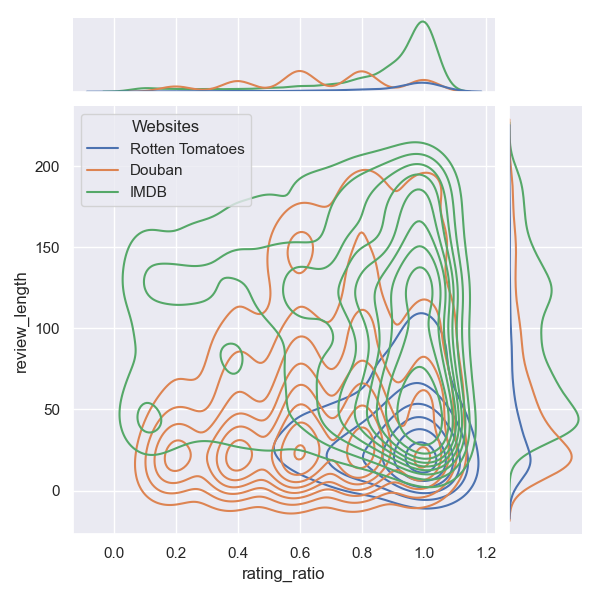

In [27]:
ax = sns.jointplot(df.query('review_length <= 200 and review_length >= 10'),
x="rating_ratio", y="review_length", hue="website", kind="kde")
sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(0, 1), title='Websites')


Next, we can see how many reviews from each website have like ratio:

In [34]:
df[df['like_ratio'].notna() & (df['like_ratio'] != 0)]['website'].value_counts()


website
IMDB      3818
Douban      73
Name: count, dtype: int64

Mostly IMDB reviews have like retios, but Douban also have some. We can plot them to discover some trends:

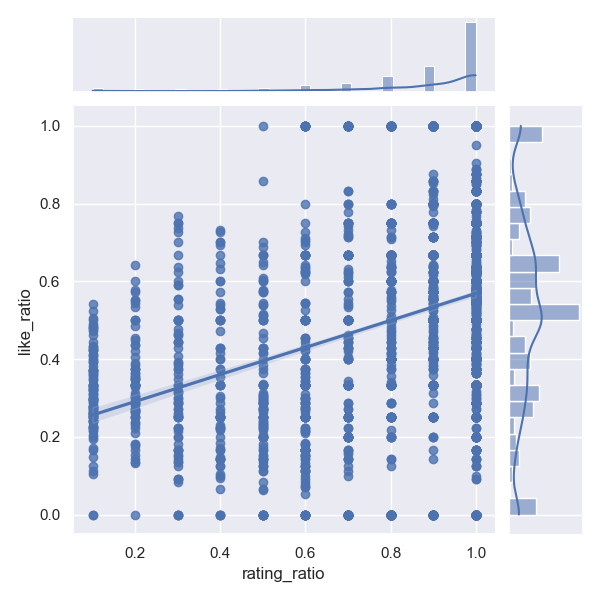

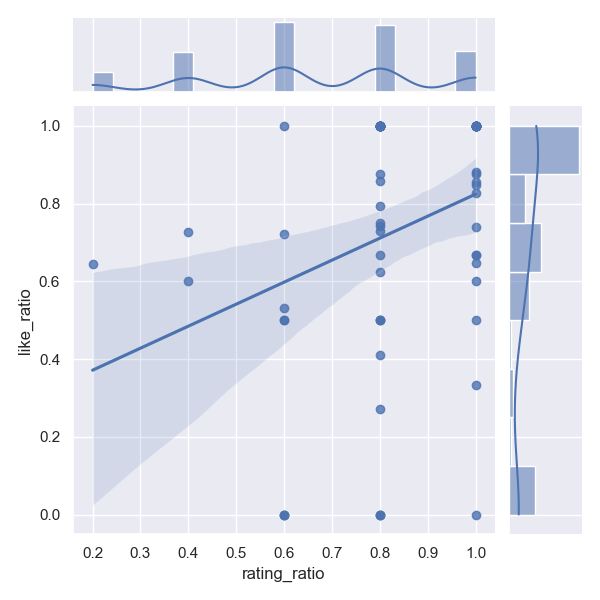

In [39]:
ax = sns.jointplot(df[df['website'] == 'IMDB'], x="rating_ratio", y="like_ratio", kind="reg")
ax = sns.jointplot(df[df['website'] == 'Douban'], x="rating_ratio", y="like_ratio", kind="reg")



It seems that positive reviews tend to have a higher like ratio. IMDB reviews' like ratios are in general a bit lower than Douban's.

There are more trends to be discovered, I won't go into details here.

# 3 - Creating Sub Dataframes

Before we process our data with [Spacy](https://spacy.io/), we need to create the subdataframe with the data we want to process.

Most importantly is seperating the language. In the code below, we will focus on Chinese reviews from Douban and English reviews from IMDB:


In [44]:
zh_df = df.query("website == 'Douban'")
zh_df.sample(3)

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio,review_length,rating_level,like_level
1881,2022-12-27,3/5,0.6,这种美式战狼电影，真扯淡的没边～,Douban,上海,1.0,NaN,NaN,NaN,NaN,16,Ok (4~8/10),None
2922,2022-05-28,5/5,1.0,看之前正在为德州枪击案EMO并在内心痛斥美丽国的安全，看之后大声感叹美丽国真好！我也想开飞机...,Douban,,9.0,NaN,NaN,NaN,NaN,108,Good (>=8/10),None
3286,2023-07-05,3/5,0.6,片子非常一般，但是这个片子让我明白了阿汤哥为啥要挑战身体极限了。好莱坞真正的超人,Douban,北京,0.0,NaN,NaN,NaN,NaN,40,Ok (4~8/10),None


In [52]:
en_df = df.query("website == 'IMDB'")
en_df.sample(3)

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio,review_length,rating_level,like_level
3684,2022-05-29,6/10,0.6,A throwback to 1980's movies: This is a slight...,IMDB,NaN,40.0,116.0,/review/rw8186834/?ref_=tt_urv,NaN,0.344828,219,Ok (4~8/10),Somewhat Disgree (20%~50%)
5085,2022-07-31,10/10,1.0,amazing: This was simply amazing. Pure enterta...,IMDB,NaN,3.0,5.0,/review/rw8387667/?ref_=tt_urv,NaN,0.600000,47,Good (>=8/10),Somewhat Agree (50%~80%)
5744,2022-06-01,10/10,1.0,Go see it ! Now: Everything you want from an a...,IMDB,NaN,3.0,4.0,/review/rw8195195/?ref_=tt_urv,NaN,0.750000,49,Good (>=8/10),Somewhat Agree (50%~80%)


# 4 - Text Processing with Spacy

The auto_nlp_process function will return tokens, ngrams and named entities.

You need to specify the right language [model](https://spacy.io/models) to use.

NOTE: depending on how many data you have, it might take a while to run.

In [46]:
from src.film_review_explorer import auto_nlp_process
from src.film_review_explorer import TextProcessor

processor = TextProcessor("zh_core_web_sm")  # for Chinese we can use the "zh_core_web_sm" model

auto_nlp_process(zh_df, processor, language='zh')
zh_df.sample(3)

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"],
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["entities"],
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio,review_length,rating_level,like_level,tokens,entities,bigrams,trigrams,quadgrams
2911,2023-02-04,4/5,0.8,视觉与肾上腺素都超越了前作，“美国精神”提名了奥斯卡。,Douban,山东,0.0,NaN,NaN,NaN,NaN,27,Good (>=8/10),None,"[视觉, 肾上腺素, 超越, 前作, 美国, 精神, 提名, 奥斯卡]","[美国, 奥斯卡]",[美国精神],[],[]
3072,2022-05-29,5/5,1.0,4.5用高速剪輯塑造的速度感、巨星演員的臉孔特寫、經典三幕劇結構、當然還有俗套但有效的最後一...,Douban,,5.0,NaN,NaN,NaN,NaN,214,Good (>=8/10),None,"[高速, 剪輯, 塑造, 速度感, 巨星, 演員, 臉孔, 特寫, 經典, 三幕劇, 結構,...","[三幕劇, MI, 一百, 阿湯哥還, 十年, 柯南伯格, 今年, 納給, 阿湯哥]","[高速剪輯, 剪輯塑造, 巨星演員, 臉孔特寫, 經典三幕劇, 三幕劇結構, 當然還, 秒營...","[高速剪輯塑造, 經典三幕劇結構, 亂入MI, MI有點, I有點跳戲, 有點跳戲之外, D...","[亂入MI有點, MI有點跳戲, I有點跳戲之外, 諾蘭下次拍動作戲, 下次拍動作戲前, 拍..."
3372,2023-06-28,5/5,1.0,什么是国际巨星啊？（后仰）优缺点一致：太太太工整了，每个环节都严丝合缝一丝不苟，但架不住所有...,Douban,山东,0.0,NaN,NaN,NaN,NaN,128,Good (>=8/10),None,"[国际, 巨星, 后仰, 优缺点, 太, 太太, 工整, 环节, 严丝合缝, 一丝不苟, 架...","[优缺点, 第三, 联想, 速8, 2022年, 九十年代]","[国际巨星, 太太太, 太太工整, 严丝合缝一丝不苟, 架不住所有人, 猜到结尾, 远超预期...","[太太太工整, 超级第三幕, 说真得劲]",[]


In [53]:
processor = TextProcessor("en_core_web_sm")  # for English we can use the "en_core_web_sm" model

auto_nlp_process(en_df, processor, language='en')
en_df.sample(3)

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"],
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["entities"],
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,date,rating,rating_ratio,review,website,location,upvotes,total_votes,permalink,comments,like_ratio,review_length,rating_level,like_level,tokens,entities,bigrams,trigrams,quadgrams
3833,2022-08-06,8/10,0.8,Sequel it deserved: .and one we've been waitin...,IMDB,NaN,4.0,7.0,/review/rw8408124/?ref_=tt_urv,NaN,0.571429,34,Good (>=8/10),Somewhat Agree (50%~80%),"[sequel, deserve, .and, wait, exhilarate, keep...","[one, second]",[seat till],[],[]
4969,2022-08-25,10/10,1.0,Sequel to Top Gun (1986): Do yourself a favor ...,IMDB,NaN,2.0,7.0,/review/rw8486461/?ref_=tt_urv,NaN,0.285714,75,Good (>=8/10),Somewhat Disgree (20%~50%),"[sequel, Gun, favor, watch, Gun, time, tie, sm...","[1986, first, first, second, 10]","[movie continues, fast moving, moving action, ...",[fast moving action],[]
6365,2022-08-05,5/10,0.5,Over rated: This film has been over rated by t...,IMDB,NaN,4.0,10.0,/review/rw8402645/?ref_=tt_urv,NaN,0.400000,71,Ok (4~8/10),Somewhat Disgree (20%~50%),"[rate, film, rate, critic, okay, flight, seque...",[first],"[flight sequences, character development, love...",[great film like],[]


We can then create a dataframe with the term frequency (tf), document frequency (df), and term frequency–inverse document frequency ([tfidf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) of tokens.

NOTE: You can calculate these for ngrams and entities as well!

In [54]:
from src.film_review_explorer import create_tfidf_df

zh_tfidf = create_tfidf_df(zh_df)
zh_tfidf

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1


,tf,df,idf,tfidf
object,,,,
电影,937,485,1.827175,1712.063095
阿汤哥,686,394,2.034973,1395.991553
部,678,384,2.060681,1397.142034
美国,505,367,2.105962,1063.510896
说,458,230,2.573245,1178.546077
...,...,...,...,...
并存,2,2,7.318177,14.636354
骑重机,2,2,7.318177,14.636354
配大,2,2,7.318177,14.636354


In [55]:
en_tfidf = create_tfidf_df(en_df)
en_tfidf

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1


,tf,df,idf,tfidf
object,,,,
movie,9687,3180,0.383665,3716.558778
film,4192,1586,1.079331,4524.554096
good,3874,2198,0.752998,2917.113942
Gun,2956,1510,1.128436,3335.657186
Maverick,2718,1231,1.332719,3622.330048
...,...,...,...,...
ravish,2,2,7.755154,15.510308
grate,2,2,7.755154,15.510308
advisor,2,2,7.755154,15.510308


# 5 - Plotting and Exploring

We can use wordcloud, key-word-in-context(kwic) and count keywords to discover trends.

First, we create a wordcloud based on term frequency of tokens:

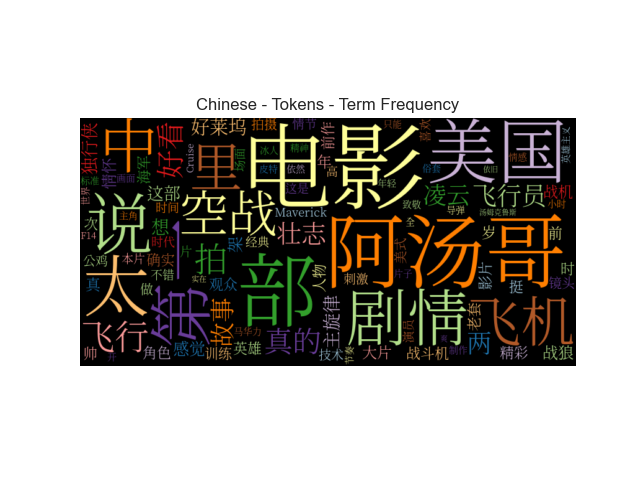

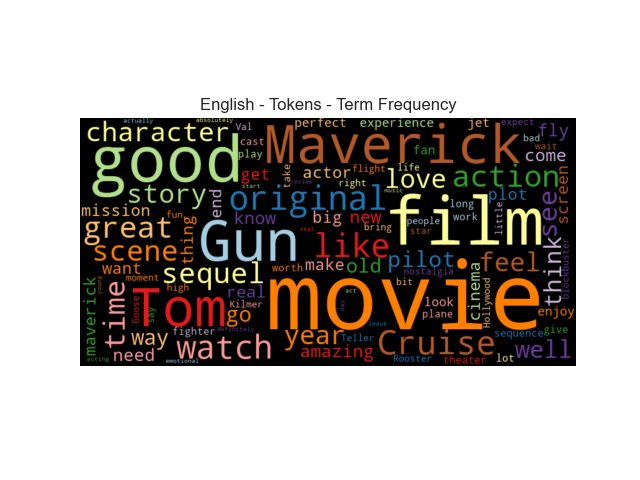

In [56]:
from src.film_review_explorer import wordcloud

wordcloud(zh_tfidf['tf'], title='Chinese - Tokens - Term Frequency', language = 'zh')
wordcloud(en_tfidf['tf'], title='English - Tokens - Term Frequency', language = 'en')

We can see that most frequent words for both languages are to-be-expected, like "movie", "Tom", "good", etc.

But there are some notable differences:
1. Most frequent words in Chinese reviews but not so frequent in English: "America", "first", "plane", "main melody" ("主旋律", a propaganda term)
2. Most frequent words in Englsih reviews but not so frequent in Chinese: "character", "original"

We can also calculate the ngrams and plot them, here I will only do bigrams:

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1


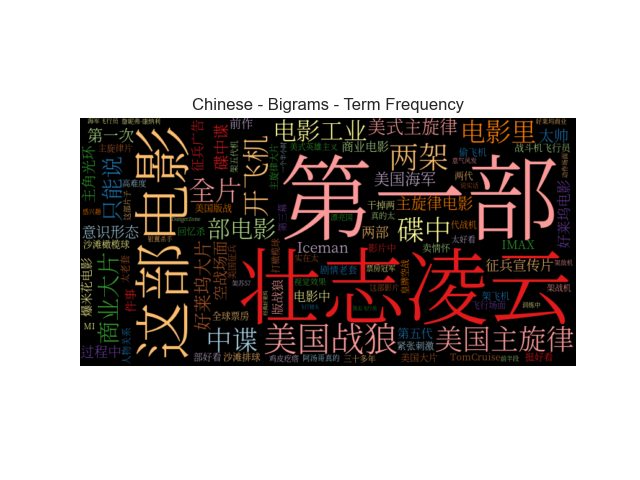

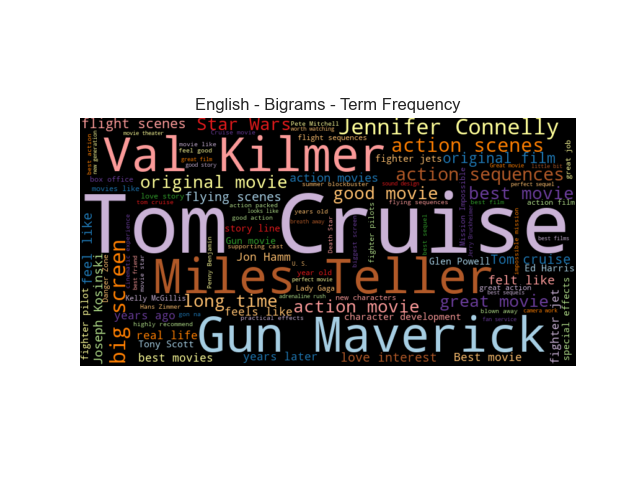

In [57]:
zh_bigram= create_tfidf_df(zh_df, column='bigrams')
en_bigram= create_tfidf_df(en_df, column='bigrams')

wordcloud(zh_bigram['tf'], title='Chinese - Bigrams - Term Frequency', language = 'zh')
wordcloud(en_bigram['tf'], title='English - Bigrams - Term Frequency', language = 'en')


Some interesting observations:
1. Many frequent bigrams in Chinese reviews are very political: "American Wolf Warrior" (reference to a successful Chinese action flick), "American propaganda", "ideology", "military recruitment advertisement"
2. The English ones are a bit generic, we can try out trigram:

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1


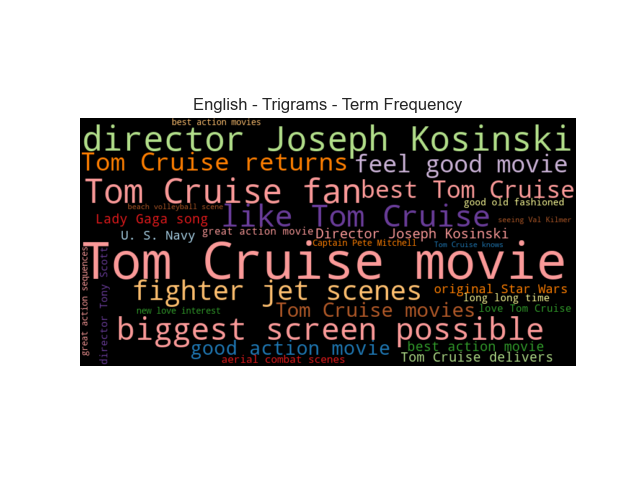

In [60]:
en_trigram= create_tfidf_df(en_df, column='trigrams')
wordcloud(en_trigram['tf'], title='English - Trigrams - Term Frequency', language = 'en', max_words=30)  # show less words, more readable

English reviews seem to overly focus on film making, like actors, directors, music, scenes. There is a mention of the US Navy though.

We can also devide Douban reviews into 3 dataframes according to their rating level, and plot them based to see what aspects people who like and dislike the film focus on:

/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1
/Users/pipchang/Documents/VSC/Projects/DH-L/DH_L/src/film_review_explorer/dataframe_preprocessor.py:330:

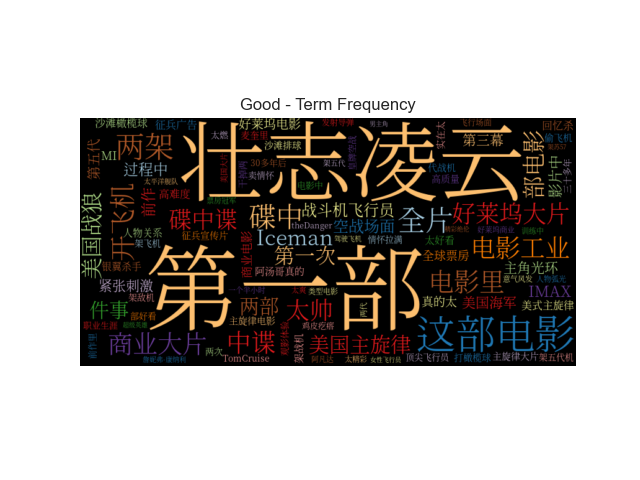

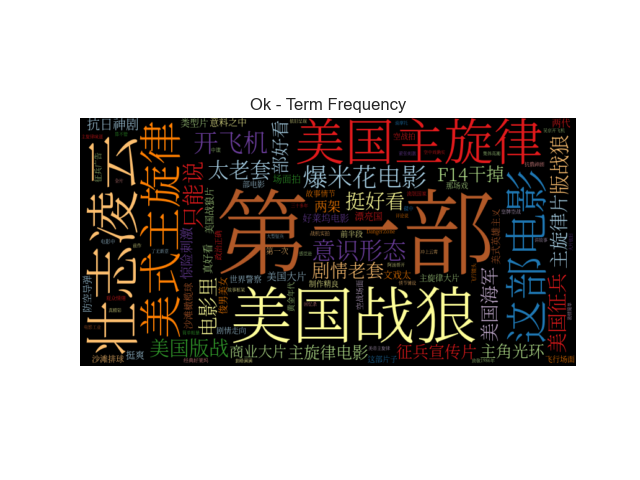

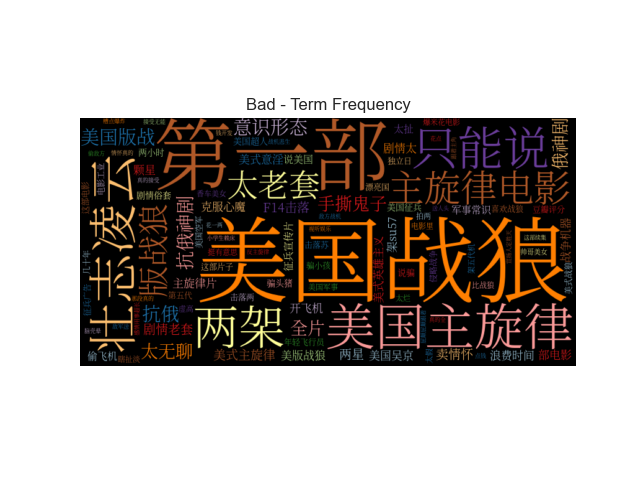

In [63]:
good_df = zh_df.query('rating_level == "Good (>=8/10)"')
ok_df = zh_df.query('rating_level == "Ok (4~8/10)"')
bad_df = zh_df.query('rating_level == "Bad (<=4/10)"')

good_tfidf = create_tfidf_df(good_df, column='bigrams')
ok_tfidf = create_tfidf_df(ok_df, column='bigrams')
bad_tfidf = create_tfidf_df(bad_df, column='bigrams')

wordcloud(good_tfidf['tf'], title='Good - Term Frequency', language = 'zh')
wordcloud(ok_tfidf['tf'], title='Ok - Term Frequency', language = 'zh')
wordcloud(bad_tfidf['tf'], title='Bad - Term Frequency', language = 'zh')

Some interesting observations:
1. Positive reviews are mostly focused on film making aspects: 'Hollywood Blockbuster', 'film industry', 'air combat scene'
2. Ok reviews are mostly about the plot and political patriotism: 'cliche plot', 'popcorn film', 'deus ex machina', 'American mainstream', 'recruitment advertisement'
3. Negative reviews make a lot of references to tension in international relation: 'anti-Russian propaganda', 'world police', 'American hero complex', 'anti-Japanese film', 'independece'


When you want to know the context around a word, you can use the kwic function.

For example, the anti-Russian mentions in Chinese reviews are quite interesting. You wonder if English reviews also mention "Russia":

In [67]:
from src.film_review_explorer import kwic

kwic(en_df['review'], keyword='Russia', window=60, print_samples=20)

20 random samples out of 56 contexts for 'Russia':
nemy fighter jets which are SU-57 NATO designation "Felon",  Russia 's 5th Gen aircrafts) was used for the flight/dogfight scene
 the next gen fighter planes is. The only possibilities are  Russia  and China.
ssion to destroy a plant that has nuclear weapons in Mother  Russia . Tension brews during the training between Cruise & Teller 
se = Obi Wan KenobiVal Kilmer = YodaRooster = Luke Skywalker Russia n Base (they don't come out and say it, but it's clearly Rus
st someone's bubble" or whether someone likes it or not.The  Russia ns definetely didn't waste their time. since their defeat: t
ain others to take out an UNKNOWN ENEMY'S (but we know it's  Russia ) Uranium cracking plant. This avoids some of the silly plot
w what the mission is, im not asking for the same ol cliche  russia n villian, just a bit more info.The fighting scenes are grea
ared enemies to the free World?! (Syria, Iran, North Korea,  Russia , etc.).OK, if you do not w

The above samples are quite political as well, though there are only 56 of them in around 4000 reviews.

You can also use count_keywords_by to compare the occurances of different words across different sorting type:

In [72]:
from src.film_review_explorer import count_keywords_by

keywords = ['military', 'world', 'China', 'Russia', 'America']
count_df = count_keywords_by(en_df, by='rating_ratio', keywords=keywords)
count_df


,military,world,China,Russia,America
rating_ratio,,,,,
0.1,11,24,0,0,3
0.2,13,3,1,1,1
0.3,25,9,2,1,2
0.4,17,6,0,0,2
0.5,32,15,3,2,5
0.6,40,23,1,5,7
0.7,21,19,1,1,4
0.8,31,46,3,4,15
0.9,44,45,4,4,16


<AxesSubplot: xlabel='rating_ratio'>

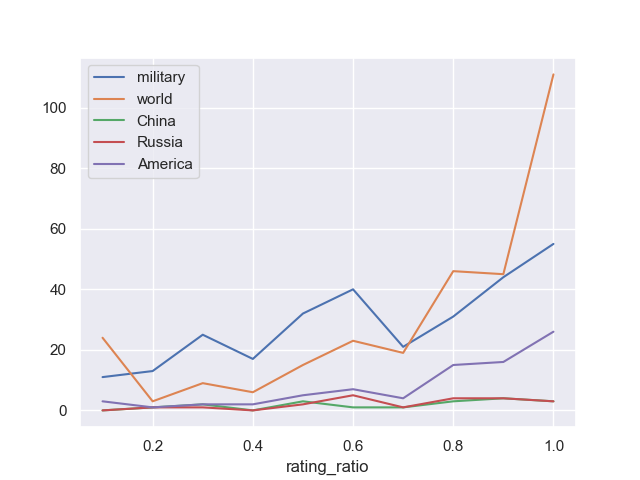

In [73]:
count_df.plot(kind='line')